# Fake News Prediction: Machine Learning Classifier Models 

## Import Dependencies

In [94]:
from google.colab import drive
drive.mount('drive')
import pickle 
from io import StringIO
import pandas as pd
import requests
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string
string.punctuation

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [95]:
import os
spark_version = 'spark-3.3.0'
os.environ['SPARK_VERSION']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [2,093 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main amd64 Packages [1,073 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:13 https://developer.download.nvid

In [96]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 55 kB/s 
     |████████████████████████████████| 199 kB 73.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=2c258a18499fcd7f3808a4e4c7bfee3908eff853a43572963dabe65152b93a9b
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [97]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NNModel").getOrCreate()

## Load Data into DataFrames

In [99]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://s3.eu-west-2.amazonaws.com/truenewscsv/Fake.csv"
spark.sparkContext.addFile(url)
fake_news_df = spark.read.csv(SparkFiles.get("Fake.csv"), sep=",", header=True)
# pyspark to pandas
fake_df = fake_news_df.toPandas()
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [100]:
url2 ="https://s3.eu-west-2.amazonaws.com/truenewscsv/True.csv"
spark.sparkContext.addFile(url2)
true_news_df = spark.read.csv(SparkFiles.get("True.csv"), sep=",", header=True)
# pyspark to pandas
true_df = true_news_df.toPandas()
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Data Exploration

In [5]:
fake_df.nunique()

title      17903
text       17455
subject        6
date        1681
dtype: int64

In [6]:

true_df.nunique()

title      20826
text       21192
subject        2
date         716
dtype: int64

In [7]:
fake_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [8]:
true_df['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [9]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [11]:
fake_df.duplicated().sum()

3

In [12]:
true_df.duplicated().sum()

206

In [13]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [14]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [15]:
fake_df.shape

(23481, 4)

In [16]:
true_df.shape

(21417, 4)

## Data Transformation
### Add `class` column, merge Dataframes, Clean Data

In [17]:
true_df['class'], fake_df['class'] = 1, 0

merged_df = pd.concat([true_df, fake_df], ignore_index = True, sort = False)

In [18]:
import copy
news_df = copy.deepcopy(merged_df)

In [19]:
import re
URLS = r'(https?://\S+)'
news_df['urlcount'] = news_df['date'].apply(lambda x: re.findall(URLS, x)).str.len()

news_df.loc[news_df['urlcount'] > 0]

,title,text,subject,date,class,urlcount
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0,1
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0,1
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0,1
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,1
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0,1
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,1
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0,1
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,1
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0,1


In [20]:
news_df['urlcount'].sum()

9

In [21]:
news_df.drop(news_df.loc[news_df['urlcount'] > 0].index, inplace=True)

In [22]:
news_df['urlcount'].sum()

0

In [23]:
news_df.duplicated().sum()

209

In [24]:
news_df.drop_duplicates(inplace=True)

In [25]:
news_df.duplicated().sum()

0

In [26]:
news_df.columns

Index(['title', 'text', 'subject', 'date', 'class', 'urlcount'], dtype='object')

In [27]:
news_df.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44680 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44680 non-null  object
 1   text      44680 non-null  object
 2   subject   44680 non-null  object
 3   date      44680 non-null  object
 4   class     44680 non-null  int64 
 5   urlcount  44680 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [28]:
news_df.shape

(44680, 6)

In [29]:
news_df['class'].value_counts()

0    23469
1    21211
Name: class, dtype: int64

In [30]:
news_df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6833
left-news           4457
Government News     1568
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [31]:
news_df.drop(['text', 'date', 'subject', 'urlcount'], axis = 1, inplace = True)
news_df

,title,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [32]:
news_df.shape

(44680, 2)

In [33]:
news_df

,title,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [35]:
news_df.to_csv('news_df.csv', encoding='utf-8', index=False)
!cp news_df.csv "drive/My Drive/"

In [36]:
news_df.columns

Index(['title', 'class'], dtype='object')

In [37]:
# Shuffle the rows randomly
news_df = news_df.sample(frac = 1)

## Data Preprocessing

In [38]:
# Import Dependencies for preprocessing
import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [39]:
news_df.head()

,title,class
12071,Mexican human rights group mulls legal action ...,1
20959,Haley says new North Korea sanctions unlikely ...,1
13953,"Freed Pakistani militant rails against India, ...",1
10992,New Hampshire to test broader appeal of Cruz's...,1
40985,COMEDIAN TIM ALLEN On Hollywood Hypocrites: Th...,0


In [40]:
# Create function to lower_case all title text data 
def lower_title(x):
  try:
    return x.lower()
  except Exception as e:
    print('Error in lower_title function', str(e))
    print("Error", x)
    return x

In [41]:
# Create function for preprocessing Title Text data

def process_text(dataframe=None, column=None):

      porter = PorterStemmer()
      tokenizer = RegexpTokenizer(r'\w+')

      dataframe[column] = dataframe[column].replace('[^a-zA-Z0-9]', '')
      dataframe[column] = dataframe[column].apply(lambda x: lower_title(x))

      dataframe = dataframe.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
      dataframe[column] = dataframe[column].apply(lambda x:tokenizer.tokenize(x))
      eng_stopwords = stopwords.words('english') 

      dataframe[column] =dataframe[column].apply(lambda words: [word for word in words if word not in eng_stopwords])
      dataframe[column] = dataframe[column].apply(lambda x : ' '.join([porter.stem(token) for token in x]))

In [42]:
# Run the text processing function on the title column
process_text(dataframe=news_df, column='title')

In [43]:
news_df

,title,class
12071,mexican human rights group mulls legal action ...,1
20959,haley says new north korea sanctions unlikely ...,1
13953,"freed pakistani militant rails against india, ...",1
10992,new hampshire to test broader appeal of cruz's...,1
40985,comedian tim allen on hollywood hypocrites: th...,0
...,...,...
12297,britain expresses grave concerns over arrest o...,1
202,trump's attack on senator gillibrand 'nasty': ...,1
36595,oh brother! white house compares obama to the ...,0
24773,trump just got a secret intel briefing from a...,0


In [44]:
news_df['class'].value_counts()

0    23469
1    21211
Name: class, dtype: int64

## Compile, Fit (Train) and Evaluate the Models

In [45]:
# Import Dependencies for ML models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn import svm

In [46]:
# Split Data into Target and Label and then into Test and Train 
X = news_df['title']
y = news_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)

In [47]:
# Vectorize title text to numbers
vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

## Train Individual Models

In [54]:
# Initializaing the NaiveBayes classifier MultinomialNB
NB_classifier = MultinomialNB()

# Training the model
NB = NB_classifier.fit(X_train, y_train)

# Testing the model
NB_y_pred = NB_classifier.predict(X_test)
NB_accuracy = accuracy_score(NB_y_pred, y_test)
NB_recall = recall_score(NB_y_pred, y_test)
NB_precision = precision_score(NB_y_pred, y_test)
NB_f1score = f1_score(NB_y_pred, y_test)

print('Results for MultinomialNB:')
print(f'Prediction: {NB_y_pred}')
print(f'Accuracy: {NB_accuracy}')
print(f'Recall: {NB_recall}')
print(f'Precision: {NB_precision}')
print(f'F1_Score: {NB_f1score}')

Results for MultinomialNB:
Prediction: [1 0 0 ... 0 0 1]
Accuracy: 0.9420769919427037
Recall: 0.9471763349980792
Precision: 0.9298510277201584
F1_Score: 0.9384337234751166


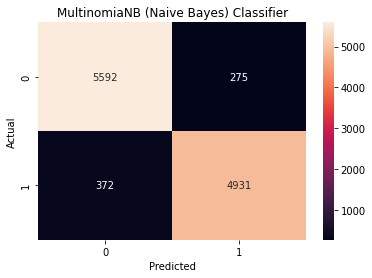

In [71]:
# Confusion matrix

data = {'y_Actual': y_test,
        'y_Predicted': NB_y_pred
        }

NB_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(NB_df['y_Actual'], NB_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt='g')
ax.set_title('MultinomiaNB (Naive Bayes) Classifier')
plt.savefig('drive/My Drive/nb_cm',dpi=300)
plt.show()

In [72]:
# Save the comparison dataframe of classifier models to csv
NB_df.to_csv('MultinomiaNB.csv', encoding='utf-8', index=False)
!cp MultinomiaNB.csv 'drive/MyDrive/'

In [73]:
#Download model with pickle
with open('drive/MyDrive/MultinomialNB.pkl', 'wb') as files:
    pickle.dump(NB, files)
    !cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [ ]:
# Upload the saved model
NB_model = pickle.load(open('drive/MyDrive/MultinomialNB.pkl', 'rb'))
!cat drive/MyDrive/
NB_y_pred = NB_model.predict(X_test)

In [75]:
print(classification_report(y_test, NB_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5867
           1       0.95      0.93      0.94      5303

    accuracy                           0.94     11170
   macro avg       0.94      0.94      0.94     11170
weighted avg       0.94      0.94      0.94     11170



In [56]:
# Initializing the RandomForestClassifier
RF_classifier = RandomForestClassifier()

# Training the model
RF = RF_classifier.fit(X_train, y_train)

# Testing the model
RF_y_pred = RF_classifier.predict(X_test)
RF_accuracy = accuracy_score(RF_y_pred, y_test)
RF_recall = recall_score(RF_y_pred, y_test)
RF_precision = precision_score(RF_y_pred, y_test)
RF_f1score = f1_score(RF_y_pred, y_test)

print('Results for RandomForestClassifier:')
print(f'Prediction: {RF_y_pred}')
print(f'Accuracy: {RF_accuracy}')
print(f'Recall: {RF_y_pred}')
print(f'Precision: {RF_accuracy}')
print(f'F1_Score: {RF_f1score}')

Results for RandomForestClassifier:
Prediction: [1 0 0 ... 0 1 1]
Accuracy: 0.9362578334825425
Recall: [1 0 0 ... 0 1 1]
Precision: 0.9362578334825425
F1_Score: 0.9341106792522672


In [58]:
print(classification_report(y_test, RF_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5867
           1       0.92      0.95      0.93      5303

    accuracy                           0.94     11170
   macro avg       0.94      0.94      0.94     11170
weighted avg       0.94      0.94      0.94     11170



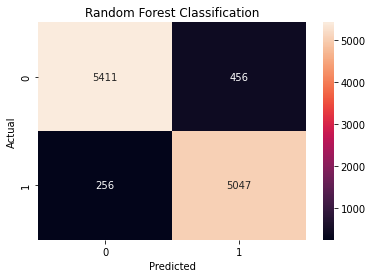

In [76]:
# Confusion matrix 

data = {'y_Actual': y_test,
        'y_Predicted': RF_y_pred
        }

RF_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(RF_df['y_Actual'], RF_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt='g')
ax.set_title('Random Forest Classification')
plt.savefig('drive/My Drive/rf_cm',dpi=300)
plt.show()

In [82]:
# Save the comparison dataframe of classifier models to csv
RF_df.to_csv('RandomForest.csv', encoding='utf-8', index=False)
!cp RandomForest.csv 'drive/MyDrive/'

In [79]:
import pickle 

with open('drive/MyDrive/RandomForestClassifier.pkl', 'wb') as files:
    pickle.dump(RF, files)
    !cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [51]:
# Upload the saved model
RF_model = pickle.load(open('drive/MyDrive/RandomForestClassifier.pkl', 'rb'))
!cat drive/MyDrive/
RF_y_pred = RF_model.predict(X_test)

In [59]:
# Initializing the AdaBoostClassifier
AB_classifier = AdaBoostClassifier()

# Training the model
AB = AB_classifier.fit(X_train, y_train)

# Testing the model
AB_y_pred = AB_classifier.predict(X_test)

AB_accuracy = accuracy_score(AB_y_pred, y_test)
AB_recall = recall_score(AB_y_pred, y_test)
AB_precision = precision_score(AB_y_pred, y_test)
AB_f1score = f1_score(AB_y_pred, y_test)

print('Results for AdaBoostClassifier:')
print(f'Prediction: {AB_y_pred}')
print(f'Accuracy: {AB_accuracy}')
print(f'Recall: {AB_recall}')
print(f'Precision: {AB_precision}')
print(f'F1_Score: {AB_f1score}')

Results for AdaBoostClassifier:
Prediction: [1 0 0 ... 1 1 1]
Accuracy: 0.8367054610564011
Recall: 0.7693975530432089
Precision: 0.9368282104469169
F1_Score: 0.8448979591836736


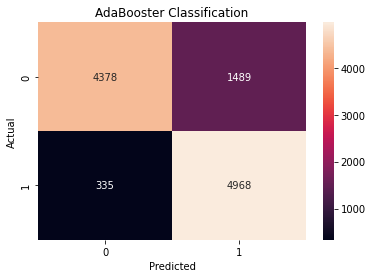

In [80]:
# Confusion matrix
data = {'y_Actual': y_test,
        'y_Predicted': AB_y_pred
        }

AB_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(AB_df['y_Actual'], AB_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt='g')
ax.set_title('AdaBooster Classification')
plt.savefig('drive/My Drive/ab_cm',dpi=300)
plt.show()

In [81]:
AB_df.to_csv('AdaBooster.csv', encoding='utf-8', index=False)
!cp AdaBooster.csv 'drive/MyDrive/'

In [83]:
#Download model with pickle
import pickle 
with open('drive/MyDrive/AdaBoostClassifier.pkl', 'wb') as files:
    pickle.dump(AB, files)
    !cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [ ]:
# Upload the saved model
AB_model = pickle.load(open('drive/MyDrive/AdaBoostClassifier.pkl', 'rb'))
AB_y_pred = AB_model.predict(X_test)

In [61]:
# Initializing the PassiveAggressiveClassifier
PA_classifier = PassiveAggressiveClassifier()

# Training the model
PA = PA_classifier.fit(X_train, y_train)

# Testing the model
PA_y_pred = PA_classifier.predict(X_test)

PA_accuracy = accuracy_score(PA_y_pred, y_test)
PA_recall = recall_score(PA_y_pred, y_test)
PA_precision = precision_score(PA_y_pred, y_test)
PA_f1score = f1_score(PA_y_pred, y_test)

print('Results for PassiveAggressiveClassifier:')
print(f'Prediction: {PA_y_pred}')
print(f'Accuracy: {PA_accuracy}')
print(f'Recall: {PA_recall}')
print(f'Precision: {PA_precision}')
print(f'F1_Score: {PA_f1score}')

Results for PassiveAggressiveClassifier:
Prediction: [1 0 0 ... 0 0 1]
Accuracy: 0.9408236347358997
Recall: 0.9362781954887218
Precision: 0.9392796530265887
F1_Score: 0.9377765226395556


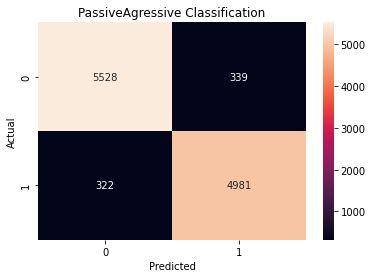

In [84]:
# Confusion matrix
data = {'y_Actual': y_test,
        'y_Predicted': PA_y_pred
        }

PA_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(PA_df['y_Actual'], PA_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt='g')
ax.set_title('PassiveAgressive Classification')
plt.savefig('drive/My Drive/pa_cm',dpi=300)
plt.show()


In [85]:
PA_df.to_csv('PassiveAgressive.csv', encoding='utf-8', index=False)
!cp PassiveAgressive.csv 'drive/MyDrive/'

In [86]:
#Download model with pickle
import pickle 
with open('drive/MyDrive/PassiveAggressiveClassifier.pkl', 'wb') as files:
    pickle.dump(PA, files)
    !cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [ ]:
# Upload the saved model
PA_model = pickle.load(open('PassiveAggressiveClassifier.pkl', 'rb'))
PA_y_pred = PA_model.predict(X_test)

In [63]:
# Initializing the KNeighborsClassifier
KNN_classifier = KNeighborsClassifier()

# Training the model
KNN = KNN_classifier.fit(X_train, y_train)

# Testing the model
KNN_y_pred = KNN_classifier.predict(X_test)

KNN_accuracy = accuracy_score(KNN_y_pred, y_test)
KNN_recall = recall_score(KNN_y_pred, y_test)
KNN_precision = precision_score(KNN_y_pred, y_test)
KNN_f1score = f1_score(KNN_y_pred, y_test)

print('Results for KNeighborsClassifier:')
print(f'Prediction: {KNN_y_pred}')
print(f'Accuracy: {KNN_accuracy}')
print(f'Recall: {KNN_recall}')
print(f'Precision: {KNN_precision}')
print(f'F1_Score: {KNN_f1score}')

Results for KNeighborsClassifier:
Prediction: [1 0 0 ... 0 0 0]
Accuracy: 0.7440465532676813
Recall: 0.8308067135896048
Precision: 0.5787290213086932
F1_Score: 0.6822274091363788


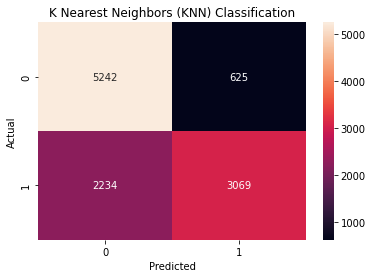

In [87]:
# Confusion matrix

data = {'y_Actual': y_test,
        'y_Predicted': KNN_y_pred
        }

KNN_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(KNN_df['y_Actual'], KNN_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt='g')
ax.set_title('K Nearest Neighbors (KNN) Classification')
plt.savefig('drive/My Drive/knn_cm',dpi=300)
plt.show()

In [88]:
KNN_df.to_csv('KNeighbors.csv', encoding='utf-8', index=False)
!cp KNeighbors.csv 'drive/MyDrive/'

In [90]:
#Download model with pickle
pickle.dump(KNN, open('drive/My Drive/KNeighborsClassifier.pkl', 'wb'), protocol=4)
!cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [ ]:
# Upload the saved model
KNN_model = pickle.load(open('KNeighborsClassifier.pkl', 'rb'))
y_pred = KNN_model.predict(X_test)

In [66]:
# Initializing the SVC
SVC_classifier = SVC()

# Training the model
SVC = SVC_classifier.fit(X_train, y_train)

# Testing the model
SVC_y_pred = SVC_classifier.predict(X_test)

SVC_accuracy = accuracy_score(SVC_y_pred, y_test)
SVC_recall = recall_score(SVC_y_pred, y_test)
SVC_precision = precision_score(SVC_y_pred, y_test)
SVC_f1score = f1_score(SVC_y_pred, y_test)

print('Results for SVC:')
print(f'Prediction: {PA_y_pred}')
print(f'Accuracy: {PA_accuracy}')
print(f'Recall: {PA_recall}')
print(f'Precision: {PA_precision}')
print(f'F1_Score: {PA_f1score}')

Results for SVC:
Prediction: [1 0 0 ... 0 0 1]
Accuracy: 0.9408236347358997
Recall: 0.9362781954887218
Precision: 0.9392796530265887
F1_Score: 0.9377765226395556


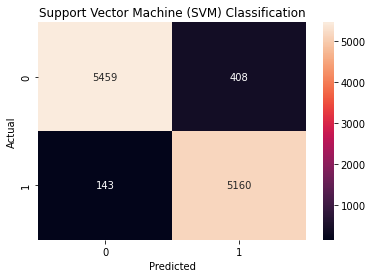

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
# Confusion matrix

data = {'y_Actual': y_test,
        'y_Predicted': SVC_y_pred
        }

SVC_df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(SVC_df['y_Actual'], SVC_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
ax = plt.axes()
sns.heatmap(confusion_matrix, annot=True, fmt='g')
ax.set_title('Support Vector Machine (SVM) Classification')
plt.savefig('drive/My Drive/svc_cm', dpi=300)
plt.show()

In [92]:
SVC_df.to_csv('SVC.csv', encoding='utf-8', index=False)
!cp SVC.csv 'drive/MyDrive/'

In [93]:
#Download model with pickle
import pickle 

with open('drive/MyDrive/SVC.pkl', 'wb') as files:
    pickle.dump(SVC, files)
    !cat drive/MyDrive/

cat: drive/MyDrive/: Is a directory


In [ ]:
# Upload the saved model
SVC_model = pickle.load(open('SVC.pkl', 'rb'))
y_pred = SVC_model.predict(X_test)

## Function to train all models

In [ ]:
# Creat function to train mutliple classifiers
def train_models(classifier_list=None, X_train=None, y_train=None, x_test=None, y_test=None):
  final_results = list()
  for name, classifier in classifier_list:
    print(f'Training {classifier}')
    classifier.fit(X_train, y_train)
   
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    f1score = f1_score(y_pred, y_test)

    final_results.append((name, accuracy, recall, precision, f1score))
    print(f'Accuracy is ==> {accuracy}')
  
  return pd.DataFrame(final_results, columns=['classifier','accuracy', 'recall', 'precision', 'f1_score'])

In [ ]:
# List of our Classifier Models
models_list = [
    ('MultinomialNB', MultinomialNB()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('PassiveAggressiveClassifier', PassiveAggressiveClassifier()),
    ('SVM', SVC())
]

In [ ]:
# Fit (train) the data using the train_models function with our classiefiers list
results_df = train_models(classifier_list=models_list, X_train=X_train, y_train=y_train, x_test=x_test, y_test=y_test)
sorted_results = results_df.sort_values(by='accuracy', ascending=False)

Training MultinomialNB()
Accuracy is ==> 0.9333930170098478
Training RandomForestClassifier()
Accuracy is ==> 0.9361683079677708
Training AdaBoostClassifier()
Accuracy is ==> 0.8461056401074306
Training KNeighborsClassifier()
Accuracy is ==> 0.7630259623992838
Training PassiveAggressiveClassifier()
Accuracy is ==> 0.9427931960608773
Training SVC()
Accuracy is ==> 0.9512085944494181


In [ ]:
sorted_results

,classifier,accuracy,recall,precision,f1_score
5,SVC,0.951209,0.928649,0.971903,0.949783
4,PassiveAggressiveClassifier,0.942793,0.935562,0.944560,0.940039
1,RandomForestClassifier,0.936168,0.918796,0.949463,0.933877
0,MultinomialNB,0.933393,0.940483,0.917782,0.928994
2,AdaBoostClassifier,0.846106,0.776714,0.948520,0.854062
3,KNeighborsClassifier,0.763026,0.831007,0.628701,0.715835


In [ ]:
# Save the dataframe holding classifier models result as csv 
sorted_results.to_csv('classifier_models.csv', encoding='utf-8', index=False)
!cp classifier_models.csv "drive/My Drive/"

In [ ]:
# Plot the resulst

import plotly.express as px

fig = px.bar(sorted_results, x='classifier', y='accuracy', text_auto='.2f', 
            title="Fake News Prediction Models Accuracy Score")
fig.show()

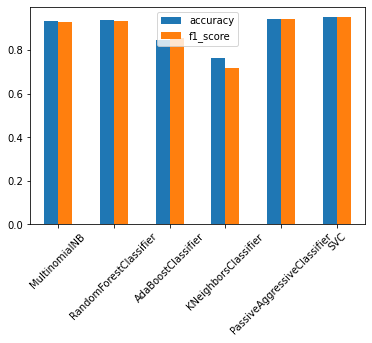

In [ ]:
# Dataframe comapring classifier models results
comparison_df = pd.DataFrame({'accuracy': list(results_df['accuracy']),
                   'f1_score': list(results_df['f1_score'])}, index=list(results_df['classifier']))
ax = comparison_df.plot.bar(rot=45)

In [ ]:
comparison_df = comparison_df.sort_values(by='accuracy', ascending=False)
comparison_df

,accuracy,f1_score
SVC,0.951209,0.949783
PassiveAggressiveClassifier,0.942793,0.940039
RandomForestClassifier,0.936168,0.933877
MultinomialNB,0.933393,0.928994
AdaBoostClassifier,0.846106,0.854062
KNeighborsClassifier,0.763026,0.715835


In [ ]:
import plotly.graph_objects as go

# Plot the accuracy and f1 scores
fig2 = go.Figure(
    data=[
        go.Bar(
            name="accuracy",
            x=sorted_results["classifier"],
            y=sorted_results["accuracy"],
            textposition='auto',
            offsetgroup=0,
        ),
        go.Bar(
            name="f1_score",
            x=sorted_results["classifier"],
            y=sorted_results["f1_score"],
            textposition='auto',
            offsetgroup=1,
        ),
    ],
    layout=go.Layout(
        title="Fake News Prediction Models Scores",
        yaxis_title="Score"
    )
)
fig2.show()

In [ ]:
# Save the comparison dataframe of classifier models to csv
comparison_df.to_csv('comparison.csv', encoding='utf-8', index=False)
!cp comparison.csv "drive/My Drive/"

In [ ]:
classifiers_url = "https://raw.githubusercontent.com/Shannon-Watts/fake_news_ML/main/notebooks/data/classifier_models.csv"
c_request = requests.get(classifiers_url).text
classifier_models = pd.read_csv(StringIO(c_request))
classifier_models

,classifier,accuracy,recall,precision,f1_score
0,SVC,0.951209,0.928649,0.971903,0.949783
1,PassiveAggressiveClassifier,0.942793,0.935562,0.944560,0.940039
2,RandomForestClassifier,0.936168,0.918796,0.949463,0.933877
3,MultinomialNB,0.933393,0.940483,0.917782,0.928994
4,AdaBoostClassifier,0.846106,0.776714,0.948520,0.854062
5,KNeighborsClassifier,0.763026,0.831007,0.628701,0.715835


In [ ]:
# exporting pandas dataframe into HTML
classifier_models.to_html('classifier_models.html')
!cp classifier_models.html "drive/My Drive/"